<a href="https://colab.research.google.com/github/aashu-0/learn-pytorch/blob/main/09_foodvision101_mini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### FoodVisionMini
so we're going to bulid and deploy foodvisionmini

criteria for our deployed model
- should work on mobile device
- make predictions fast

questions?
1. ideal ml model deployement scenario?
  - fast and works every time
2. where our model is going to be stored?
  - on device(also called edge) or cloud
3. how it's going to function?
  - online (real-time) or offine(also called batch)


**on-device**: `smaller model -> less performance -> faster inference`

**cloud**: `bigger model -> better perfomance -> slower inference`
- which one to choose?
  - it all boils down to a tradeoff b/w performance(i.e accuracy) and inference time(latency) of the model

**online**(real-time) -> `predictions made immediately`

**offline**(batch) -> `predicitons happen periodically`

let's do the code
as they say **talk is trash, show me your code**

#### Setup

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms


# installing torchmetrics and torchinfo
try:
  from torchmetrics import Accuracy
  from torchinfo import summary
except:
  print(f'[INFO] Installing torchmetrics and torchinfo')
  !pip install torchmetrics
  !pip install torchinfo

In [2]:
# custom functions import from github

try:
  from modualr_pytorch import data_setup, engine
except:
  print(f'[INFO] installing required scripts from github')
  !git clone https://github.com/aashu-0/learn-pytorch
  !mv learn-pytorch/modualr_pytorch .
  !rm -rf learn-pytorch
  from modualr_pytorch import data_setup, engine

In [3]:
# device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

#### Get data
downloading 20% data from daniel github

In [4]:
# writing a downlod_data function which download a zip folder from the src and unzip to the destination
from pathlib import Path
import requests
import zipfile
import os


def download_data(source: str,
                  destination: str,
                  remove_src: bool = True) -> Path:
  data_path = Path('data/')
  image_path = data_path / destination

  # make directory if not avaliable
  if image_path.is_dir():
    print('[INFO] file directory already exists')
  else:
    print("[INFO] file directory doesn't exists creating one")
    image_path.mkdir(parents= True, exist_ok=True)

    # download data(zip file) from source
    targ_file = Path(source).name
    with open(data_path/targ_file, 'wb') as f:
      request = requests.get(source)
      print(f'[INFO] downloading zip file')
      f.write(request.content)

    # unzip the downloaded file
    with zipfile.ZipFile(data_path/targ_file, 'r') as zip_ref:
      print(f'[INFO] unzipping...')
      zip_ref.extractall(image_path)

    # remove zip file
    if remove_src:
      os.remove(data_path/targ_file)

  return image_path

In [5]:
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent",
                                     remove_src=True)
data_20_percent_path

[INFO] file directory already exists


PosixPath('data/pizza_steak_sushi_20_percent')

In [6]:
# creating train and test directory instance

train_dir = data_20_percent_path/'train'
test_dir = data_20_percent_path/'test'

#### Creating an `EffNetB2` feature extractor


In [7]:
# a function to make effnetb2 feature extractor

def create_effnetb2_model(num_classes: int,
                          seed: int=42):

  # get pretrained weights
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  # get effnetb2 transforms
  transforms = weights.transforms()
  # model with pretrained weights
  model = torchvision.models.efficientnet_b2(weights=weights)


  # freeze all layers int the base model
  for parm in model.parameters():
    parm.requires_grad = False  #no update in their weights

  # change classifier head
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

  model.classifier = nn.Sequential(
      nn.Dropout(p=0.3, inplace=True),
      nn.Linear(in_features=1408,
                out_features=num_classes)
  )

  return model, transforms

In [8]:
# let try

effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3,
                                                      seed=42)

In [9]:
# let's have a look
from torchinfo import summary

summary(model=effnetb2,
        input_size=(1,3,224,224),
        col_names= ['input_size','output_size','num_params','trainable'],
        col_width = 20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

#### Create Dataloaders

In [10]:
from modualr_pytorch import data_setup

NUM_WORKERS= os.cpu_count()
BATCH_SIZE = 32

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform = effnetb2_transforms,
    batch_size= BATCH_SIZE,
    num_workers= NUM_WORKERS
)

train_dataloader_effnetb2, test_dataloader_effnetb2, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7e65438874d0>,
 ['pizza', 'steak', 'sushi'])

#### Training effnetb2 feature extractor

In [11]:
from torchmetrics import Accuracy
from modualr_pytorch import engine

# loss, optimizer and accuracy function
loss_fn = nn.CrossEntropyLoss()
acc_fn= Accuracy(task= 'multiclass', num_classes=len(class_names)).to(device)

optimizer = torch.optim.Adam(params=effnetb2.parameters(), lr=0.001)


#seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

effnetb2_results= engine.train(model= effnetb2,
                               train_dataloader=train_dataloader_effnetb2,
                               test_dataloader= test_dataloader_effnetb2,
                               optimizer= optimizer,

                               loss_fn= loss_fn,
                               accuracy_fn = acc_fn,
                               epochs=10,
                               device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 0.9839 | Train acc: 0.5667 | Test Loss: 0.7393 | Test acc: 0.9409
Epoch: 1 | Train Loss: 0.7135 | Train acc: 0.8396 | Test Loss: 0.5862 | Test acc: 0.9409
Epoch: 2 | Train Loss: 0.5874 | Train acc: 0.8958 | Test Loss: 0.4891 | Test acc: 0.9563
Epoch: 3 | Train Loss: 0.4488 | Train acc: 0.9146 | Test Loss: 0.4338 | Test acc: 0.9409
Epoch: 4 | Train Loss: 0.4277 | Train acc: 0.9125 | Test Loss: 0.3907 | Test acc: 0.9443
Epoch: 5 | Train Loss: 0.4392 | Train acc: 0.8896 | Test Loss: 0.3525 | Test acc: 0.9688
Epoch: 6 | Train Loss: 0.4246 | Train acc: 0.8771 | Test Loss: 0.3263 | Test acc: 0.9563
Epoch: 7 | Train Loss: 0.3885 | Train acc: 0.8979 | Test Loss: 0.3465 | Test acc: 0.9443
Epoch: 8 | Train Loss: 0.3795 | Train acc: 0.8813 | Test Loss: 0.3127 | Test acc: 0.9193
Epoch: 9 | Train Loss: 0.3752 | Train acc: 0.8688 | Test Loss: 0.2811 | Test acc: 0.9625


#### Plotting loss curves

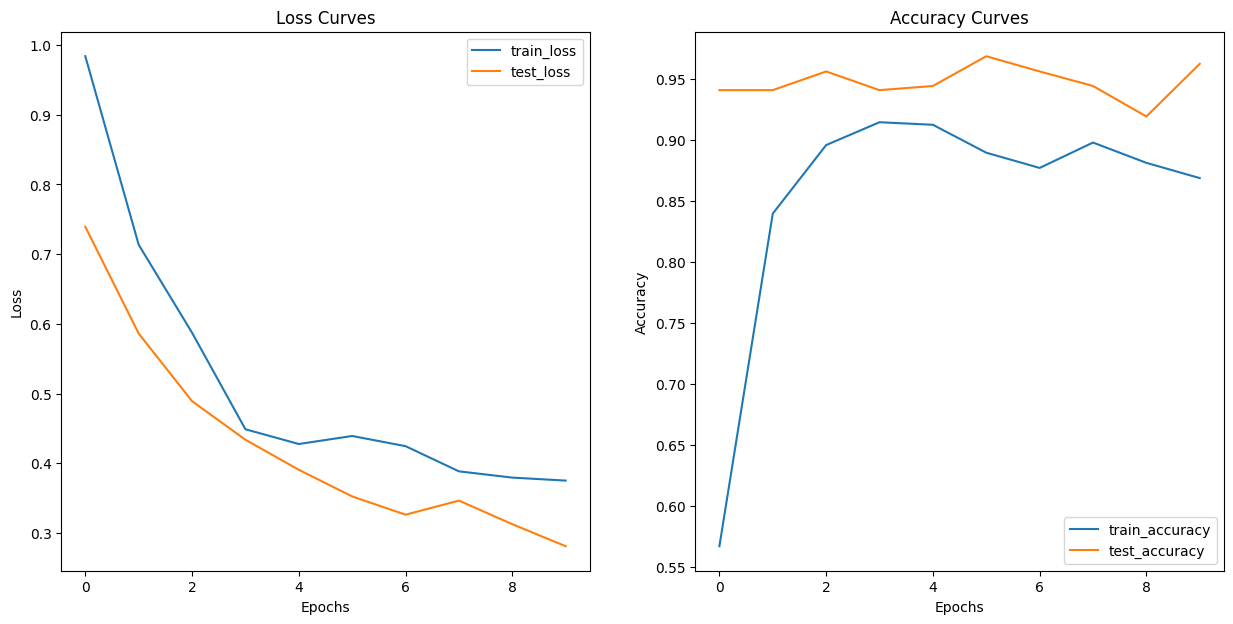

In [12]:
from typing import Tuple, Dict, List
def plot_loss_curve(results: Dict[str, List[float]]):
  # loss values
  train_loss = results['train_loss']
  test_loss = results['test_loss']

  # accuracy values
  # move tensors to the CPU before converting to numpy
  train_accuracy = [tensor.cpu() for tensor in results['train_acc']]
  test_accuracy = [tensor.cpu() for tensor in results['test_acc']]

  # epochs as list
  epochs = range(len(results['train_loss']))

  plt.figure(figsize=(15,7))

  # plot loss
  plt.subplot(1,2,1)
  plt.plot(epochs, train_loss, label ='train_loss')
  plt.plot(epochs, test_loss, label ='test_loss')
  plt.xlabel("Epochs")
  plt.ylabel('Loss')
  plt.title('Loss Curves')
  plt.legend()

  # plot accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs, train_accuracy, label ='train_accuracy')
  plt.plot(epochs, test_accuracy, label ='test_accuracy')
  plt.xlabel("Epochs")
  plt.ylabel('Accuracy')
  plt.title('Accuracy Curves')
  plt.legend()

plot_loss_curve(effnetb2_results)

In [13]:
#effnetb2_results

#### Saving EffNetB2 feature extractor

In [14]:
from modualr_pytorch import utils

utils.save_model(model=effnetb2,
                 target_dir='models',
                 model_name = '09_pretrained_effnet_feature_extractor_20_percent.pth')


Saving model to: models/09_pretrained_effnet_feature_extractor_20_percent.pth


In [15]:
# let's check our model filesize
from pathlib import Path

pretrained_effnetb2_model_size = Path('models/09_pretrained_effnet_feature_extractor_20_percent.pth').stat().st_size // (1024*1024)
print(f'{pretrained_effnetb2_model_size} MB')

29 MB


In [16]:
#count the numbers of paramaters in EffNetB2

effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [17]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1].item(),
                  "number_of_parameters": effnetb2_total_params,
                  "model_size(MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.28108686208724976,
 'test_acc': 0.9625000357627869,
 'number_of_parameters': 7705221,
 'model_size(MB)': 29}

### Creating an ViT feature extractor

In [18]:
# check vit head layer
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [19]:
# a function to create vit model extractor

def create_vit_model(num_classes: int=3,
                     seed: int=42):
  weights = torchvision.models.ViT_B_16_Weights.DEFAULT
  transforms = weights.transforms()
  model = torchvision.models.vit_b_16(weights=weights)

  # freeze all the layers
  for parm in model.parameters():
    parm.requires_grad = False  # don't track gradient

  # change classifier head
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)

  #change the classifier head
  model.heads= nn.Sequential(
      nn.Linear(in_features=768, out_features=num_classes)
  )

  return model, transforms

In [20]:
vit, vit_transforms = create_vit_model(num_classes=3,
                                       seed= 42)


In [21]:
summary(model=vit,
        input_size=(1,3,224,224),
        col_names = ["input_size","output_size","num_params","trainable",],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

#### Create Dataloader

In [22]:
from modualr_pytorch import data_setup

train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform= vit_transforms,
    batch_size= BATCH_SIZE,
    num_workers= NUM_WORKERS
)

train_dataloader_vit, test_dataloader_vit, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7e652c32c610>,
 ['pizza', 'steak', 'sushi'])

#### Training ViT feature extarctor

In [23]:
from modualr_pytorch import engine

# optimizer, accuracy and loss function
loss_fn = nn.CrossEntropyLoss()
acc_fn= Accuracy(task= 'multiclass', num_classes=len(class_names)).to(device)

optimizer = torch.optim.Adam(params=vit.parameters(), lr=0.001)

# let's train

vit_results = engine.train(model= vit,
                           train_dataloader= train_dataloader_vit,
                           test_dataloader= test_dataloader_vit,
                           optimizer= optimizer,
                           loss_fn= loss_fn,
                           accuracy_fn = acc_fn,
                           epochs = 10,
                           device = device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train Loss: 0.6173 | Train acc: 0.7854 | Test Loss: 0.2692 | Test acc: 0.9352
Epoch: 1 | Train Loss: 0.2241 | Train acc: 0.9438 | Test Loss: 0.1414 | Test acc: 0.9631
Epoch: 2 | Train Loss: 0.1539 | Train acc: 0.9563 | Test Loss: 0.1071 | Test acc: 0.9722
Epoch: 3 | Train Loss: 0.1412 | Train acc: 0.9625 | Test Loss: 0.0966 | Test acc: 0.9693
Epoch: 4 | Train Loss: 0.1058 | Train acc: 0.9667 | Test Loss: 0.0866 | Test acc: 0.9722
Epoch: 5 | Train Loss: 0.0903 | Train acc: 0.9729 | Test Loss: 0.0823 | Test acc: 0.9722
Epoch: 6 | Train Loss: 0.0783 | Train acc: 0.9792 | Test Loss: 0.0772 | Test acc: 0.9784
Epoch: 7 | Train Loss: 0.0693 | Train acc: 0.9792 | Test Loss: 0.0712 | Test acc: 0.9784
Epoch: 8 | Train Loss: 0.0615 | Train acc: 0.9896 | Test Loss: 0.0705 | Test acc: 0.9722
Epoch: 9 | Train Loss: 0.0548 | Train acc: 0.9938 | Test Loss: 0.0667 | Test acc: 0.9722


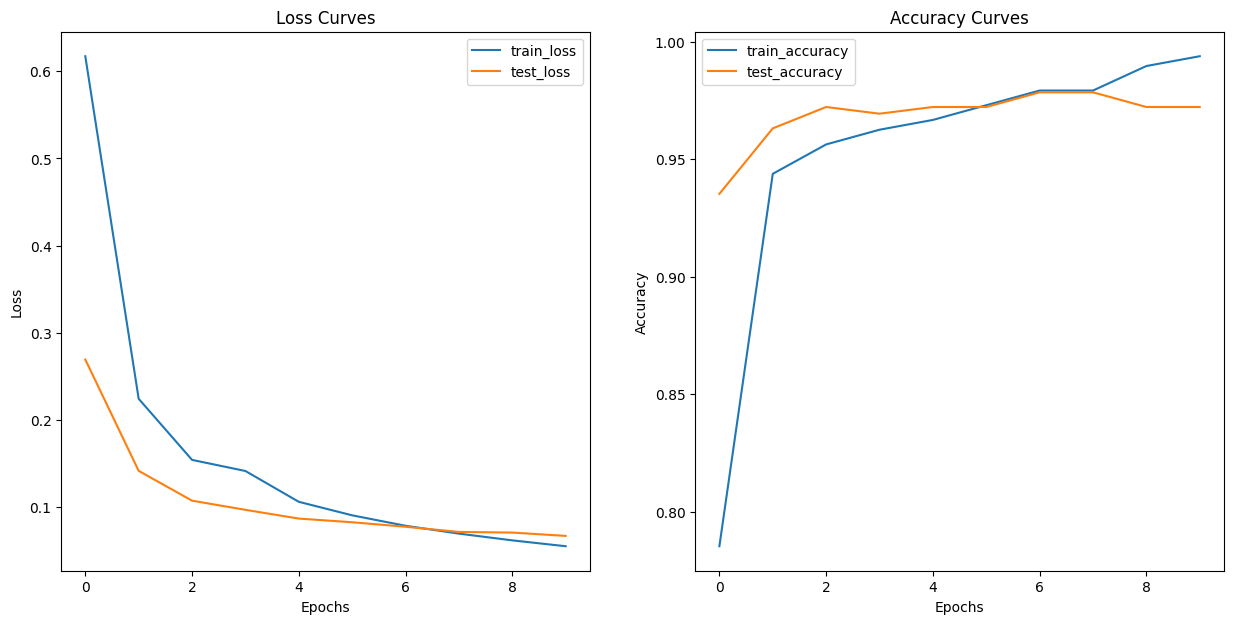

In [24]:
# plot loss curve

plot_loss_curve(vit_results)

In [25]:
#vit_results

### Saving ViT feature extractor

In [26]:
# save the model
from modualr_pytorch import utils

utils.save_model(model=vit,
                 target_dir='models',
                 model_name= '09_pretrained_vit_feature_extractor_20_percent.pth')

Saving model to: models/09_pretrained_vit_feature_extractor_20_percent.pth


In [27]:
# checking the size

from pathlib import Path
import os

model_path = Path('models/09_pretrained_vit_feature_extractor_20_percent.pth')
pretrained_vit_model_size = os.path.getsize(model_path) / (1024*1024)

print(f'pretrained vit model size: {pretrained_vit_model_size:.0f} MB')

pretrained vit model size: 327 MB


In [28]:
# total number of parameters in vit model
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [29]:
# for param in vit.parameters():
#   print(param.shape)

In [30]:
# create vit statistics dictionary
vit_stats = {'test_loss': vit_results['test_loss'][-1],
             'test_acc': vit_results['test_acc'][-1].item(),
             'number_of_parameters': vit_total_params,
             'model_size(MB)' :int(pretrained_vit_model_size)}
vit_stats

{'test_loss': 0.06667962307110428,
 'test_acc': 0.9721590876579285,
 'number_of_parameters': 85800963,
 'model_size(MB)': 327}

### Making Predictions and timing them

In [31]:
# storing all the test image path in a list

from pathlib import Path
test_data_paths = list(Path(test_dir).glob('*/*.jpg'))
test_data_paths[:5]

[PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2997525.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/204151.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2572488.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/1555015.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2250611.jpg')]

#### Creating a function to make predictions across the test dataset

In [32]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict


# create function
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
    # empty list
    pred_list =[]

    for path in tqdm(paths):

      # create empty dict
      pred_dict ={}

      pred_dict['image_path']= path
      class_name = path.parent.stem
      pred_dict['class_name'] =class_name

      # start timer
      start_time = timer()

      # open image
      img= Image.open(path)

      # transform, add batch dim, device
      transformed_img = transform(img).unsqueeze(0).to(device)

      # model for inference(or eval) mode
      model.to(device)
      model.eval()

      # make predictions
      with torch.inference_mode():
        pred_logit = model(transformed_img)
        pred_prob = torch.softmax(pred_logit, dim=1)  #tensor
        pred_label = torch.argmax(pred_prob, dim=1)
        pred_class = class_names[pred_label.cpu()]

        pred_dict['pred_prob'] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
        pred_dict['pred_class'] = pred_class

        # end timer
        end_time = timer()
        pred_dict['time_for_pred']= round(end_time-start_time, 4)

      # our pred matches with correct label
      pred_dict['correct'] = class_name == pred_class

      pred_list.append(pred_dict)

    return pred_list

#### making and timing predictions with effnetb2

In [33]:
effnetb2_test_pred_dict = pred_and_store(paths= test_data_paths,
                                         model=effnetb2,
                                         transform= effnetb2_transforms,
                                         class_names = class_names,
                                         device='cpu')

  0%|          | 0/150 [00:00<?, ?it/s]

In [34]:
effnetb2_test_pred_dict[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2997525.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9829,
  'pred_class': 'pizza',
  'time_for_pred': 0.2419,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/204151.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9278,
  'pred_class': 'pizza',
  'time_for_pred': 0.1606,
  'correct': True}]

In [35]:
# let's convert test_pred_dicts into a dataframe
import pandas as pd
effnet_b2_pred_df = pd.DataFrame(effnetb2_test_pred_dict)
effnet_b2_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.9829,pizza,0.2419,True
1,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.9278,pizza,0.1606,True
2,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.9146,pizza,0.1485,True
3,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,0.9558,pizza,0.1554,True
4,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.8142,pizza,0.1452,True


In [36]:
# let's how much our model got wrong
effnet_b2_pred_df.correct.value_counts()

,count
correct,
True,144
False,6


In [37]:
# avg prediction time per prediction
effnetb2_avg_time_per_pred = round(effnet_b2_pred_df['time_for_pred'].mean(), 4)

print(f'EffnetB2 average prediction time: {effnetb2_avg_time_per_pred} seconds')

EffnetB2 average prediction time: 0.1127 seconds


In [38]:
# add it to our effnet stats dict
effnetb2_stats['time_per_pred_cpu'] = effnetb2_avg_time_per_pred

effnetb2_stats

{'test_loss': 0.28108686208724976,
 'test_acc': 0.9625000357627869,
 'number_of_parameters': 7705221,
 'model_size(MB)': 29,
 'time_per_pred_cpu': 0.1127}

### Making and timing predictions with ViT

In [39]:
vit_test_pred_dict = pred_and_store(paths=test_data_paths,
                                    model=vit,
                                    transform =vit_transforms,
                                    class_names = class_names,
                                    device='cpu')

  0%|          | 0/150 [00:00<?, ?it/s]

In [40]:
vit_test_pred_dict[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2997525.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9989,
  'pred_class': 'pizza',
  'time_for_pred': 0.6525,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/204151.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9979,
  'pred_class': 'pizza',
  'time_for_pred': 0.3617,
  'correct': True}]

In [41]:
# turn dict into dataframe

import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dict)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.9989,pizza,0.6525,True
1,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.9979,pizza,0.3617,True
2,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.9980,pizza,0.3652,True
3,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,0.9987,pizza,0.3480,True
4,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.9987,pizza,0.3591,True


In [42]:
# let'show much our vit model got correct
vit_test_pred_df['correct'].value_counts()

,count
correct,
True,146
False,4


In [43]:
# avg prediction time per prediction
vit_avg_time_per_pred = round(vit_test_pred_df['time_for_pred'].mean(), 4)

print(f'ViT average time per prediction: {vit_avg_time_per_pred}')

ViT average time per prediction: 0.4075


In [44]:
# add avg time to Vit stat dict
vit_stats['time_per_pred_cpu'] = vit_avg_time_per_pred
vit_stats

{'test_loss': 0.06667962307110428,
 'test_acc': 0.9721590876579285,
 'number_of_parameters': 85800963,
 'model_size(MB)': 327,
 'time_per_pred_cpu': 0.4075}

#### Comapring model results, prediction times and size

In [45]:
# turn vit_stats and effnetb2_stats into dataframe

# add model column
model = ['EffNetB2', 'ViT']

df = pd.DataFrame([effnetb2_stats, vit_stats], index = model)

# accuracy to percent
df['test_acc'] = round(df['test_acc'] *100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size(MB),time_per_pred_cpu
EffNetB2,0.281087,96.25,7705221,29,0.1127
ViT,0.066680,97.22,85800963,327,0.4075


In [46]:
for model, row in df.iterrows():
  print(row['test_acc'])

96.25
97.22


#### Create a figure to visualize speed vs performance

i.e `time_per_pred_cpu` v/s `test_acc`

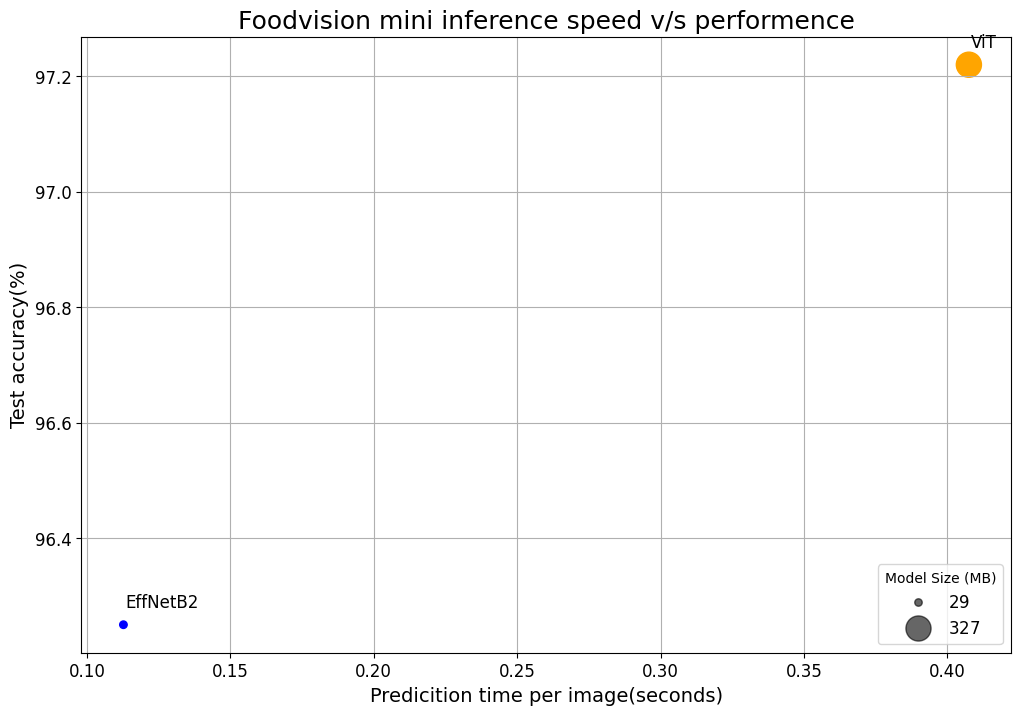

In [47]:
# create a scatterplot

fig, ax = plt.subplots(figsize=(12,8))

scatter = ax.scatter(data=df,
                         x='time_per_pred_cpu',
                         y= 'test_acc',
                         c= ['blue','orange'],
                         s = 'model_size(MB)')

# add titles, labels(
ax.set_title('Foodvision mini inference speed v/s performence', fontsize=18)
ax.set_xlabel('Predicition time per image(seconds)', fontsize=14)
ax.set_ylabel('Test accuracy(%)', fontsize = 14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

# annotate with model names
for model, row in df.iterrows():
  ax.annotate(text = model,
              xy = ((row.time_per_pred_cpu) + 0.0006, (row.test_acc)+0.03),
              size=12)

# a legend for model size on the basis of sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
legend2 = ax.legend(handles,
                    labels,
                    loc="lower right",
                    title="Model Size (MB)",
                    fontsize=12)

plt.show()

### Let's create a gradio app for effnetb2 model

In [48]:
# install gradio
try:
  import gradio as gr
except:
  !pip -q install gradio
  import gradio as gr

print(gr.__version__)

5.13.1


for gradio overview [link](https://www.learnpytorch.io/09_pytorch_model_deployment/#71-gradio-overview)


```
gr.Interface(fn, inputs, outputs)
```
`fn`: python function to map `inputs` to the `outputs`


##### create a function to map our inputs(images) to outputs

our function workflow
```
input: image -> tranform -> predict with EffNetB2 -> output: pred_prob, time_taken
```

In [49]:
# put the model on cpu
effnetb2.to('cpu')

# check
next(iter(effnetb2.parameters())).device

device(type='cpu')

In [50]:
# create a predict function to replicate the workflow
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:

  # start timer
  start_timer = timer()

  # transform
  img = effnetb2_transforms(img).unsqueeze(0)  # add batch dim

  # model on eval mode
  effnetb2.eval()
  with torch.inference_mode():

    pred_probs = torch.softmax(effnetb2(img), dim=1)

  # pred labels and pred prob dictionary for each prediction class
  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # pred time
  pred_time = round(timer()- start_timer, 5)

  return pred_labels_and_probs, pred_time

In [51]:
# let's pass a random image

import random
from PIL import Image

# get list of all test image paths
test_image_paths = list(Path(test_dir).glob('*/*.jpg'))

#select an image randomly
random_img_path = random.sample(test_image_paths, k= 1)[0]

# open the image

img = Image.open(random_img_path)
print(f'[INFO] Predicting image at path:  {random_img_path}\n')

# make prediction
pred_dict, pred_time = predict(img= img)

print(f'Prediction label and probability dictionary: \n{pred_dict}\n')
print(f'Prediction time: {pred_time} seconds')

[INFO] Predicting image at path:  data/pizza_steak_sushi_20_percent/test/sushi/2903621.jpg

Prediction label and probability dictionary: 
{'pizza': 0.18786241114139557, 'steak': 0.07185706496238708, 'sushi': 0.7402805089950562}

Prediction time: 0.14949 seconds


##### Creating a list of examples

In [52]:
example_list = [[str(filepath)] for filepath in random.sample(test_image_paths, k=6)]

example_list

[['data/pizza_steak_sushi_20_percent/test/pizza/2250611.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/pizza/1687143.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/2307638.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/2246332.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/3541033.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/steak/670345.jpg']]

#### Buliding a Gradio Interface

```
gr.Interface(fn, inputs, outputs, examples, title, description, article)
```

In [53]:
import gradio as gr

title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Made with ❤️ and 🍕"

# gradio demo
demo = gr.Interface(fn= predict,
                    inputs = gr.Image(type= 'pil'),
                    outputs= [gr.Label(num_top_classes=3, label='Predictions'),
                              gr.Number(label="Predictions time(in seconds)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article
                    )

# launch
demo.launch(debug=False, # to print errors locally
            share= True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ef64df3ca293897fa9.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


### Turning Gardio Demo into a deployable app

obviously using HF🤗 Spaces

to deploy we need to have everything into a single directory with file structure:


```
demos/
└── foodvision_mini/
    ├── 09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth
    ├── app.py
    ├── examples/
    │   ├── example_1.jpg
    │   ├── example_2.jpg
    │   └── example_3.jpg
    ├── model.py
    └── requirements.txt
```

#### Creating a `demo` folder

In [54]:
import shutil
from pathlib import Path

foodvision_mini_demo_path = Path('demos/foodvision_mini/')

# remove files (if they already exist)
if foodvision_mini_demo_path.exists():
  shutil.rmtree(foodvision_mini_demo_path)

# make dir if not exist
foodvision_mini_demo_path.mkdir(parents=True,
                                exist_ok = True)

# check folder
! ls demos/foodvision_mini

#### Create a folder of example images
in `examples/` directory within `demos/foodvision_mini`

In [55]:
import shutil
from pathlib import Path

# create examples dir
foodvision_mini_examples_path = foodvision_mini_demo_path/'examples'
foodvision_mini_examples_path.mkdir(parents=True,
                                    exist_ok = True)

# get three random images and put them in examples/
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/pizza/3375083.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3541033.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/sushi/3494950.jpg')]

# copy these images to examples dir
for example in foodvision_mini_examples:
  destination= foodvision_mini_examples_path/ example.name

  print(f'[INFO] Copying {example} to {destination}')
  shutil.copy2(src=example, dst= destination)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/3375083.jpg to demos/foodvision_mini/examples/3375083.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3541033.jpg to demos/foodvision_mini/examples/3541033.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/3494950.jpg to demos/foodvision_mini/examples/3494950.jpg


#### Moving our trained EffNetB2 model to Foodvision mini directory

In [56]:
import shutil

# create source path
effnetb2_foodvision_mini_model_path = 'models/09_pretrained_effnet_feature_extractor_20_percent.pth'

# create destination path
effnetb2_foodvision_mini_model_des = foodvision_mini_demo_path/effnetb2_foodvision_mini_model_path.split('/')[1]

try:
  print(f'[INFO] Moving Model from source to destination')

  # move
  shutil.move(src=effnetb2_foodvision_mini_model_path,
              dst= effnetb2_foodvision_mini_model_des)
  print(f'[INFO] Model moved sucessfully')

# check if model is already moved
except:
  print(f'[INFO] No model found at source location')
  print(f'[INFO] Model exists: {effnetb2_foodvision_mini_model_des.exists()}')

[INFO] Moving Model from source to destination
[INFO] Model moved sucessfully


#### Turning our EffNetB2 model into a python script


In [57]:
%%writefile demos/foodvision_mini/model.py

import torch
import torchvision

from torch import nn

def create_effnetb2_model(num_classes: int=3,
                          seed: int =42):

  #weights, transforms and model instance
  weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
  transforms = weights.transforms()

  model = torchvision.models.efficientnet_b2(weights= weights)

  # freeze all layers of base model
  for param in model.parameters():
    param.requires_grad = False  # i.e don't keep track of gradients

    # change classifier head
    torch.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features= num_classes)
    )

    return model,transforms

Writing demos/foodvision_mini/model.py


#### Turning foodvision gradio app into a python script `app.py`

In [58]:
%%writefile demos/foodvision_mini/app.py

import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# class_names
class_names = ['pizza', 'steak', 'sushi']


#create effnet model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes = len(class_names),
    seed=42
)

# load saved weights
effnetb2.load_state_dict(torch.load(
    f = '09_pretrained_effnet_feature_extractor_20_percent.pth',
    map_location=torch.device('cpu')
    )
)

# predict

def predict(img) -> Tuple[Dict, float]:

  # start timer
  start_timer = timer()

  # perform transform aadd batch dim
  img = effnetb2_transforms(img).unsqueeze(0)

  # modle on eval mode
  effnetb2.eval()
  with torch.inference_mode():

    # pass the img to the model and get pred prob
    pred_probs = torch.softmax(effnetb2(img), dim=1)

  pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  # pred time
  pred_time = round(timer() - start_timer, 5)

  # return pred dict and pred time
  return pred_labels_and_probs, pred_time

# gradio app

title = "FoodVision Mini 🍕🥩🍣"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak or sushi."
article = "Made with ❤️ and 🍕"

# create examples list
example_list = [['examples/' +example] for example in os.listdir('examples')]

# gradio demo
demo = gr.Interface(fn= predict,
                    inputs = gr.Image(type= 'pil'),
                    outputs= [gr.Label(num_top_classes=3, label='Predictions'),
                              gr.Number(label="Predictions time(in seconds)")],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article
                    )

# launch
demo.launch()


Writing demos/foodvision_mini/app.py


#### Create a `requirement.txt` file

In [59]:
torch.__version__

'2.5.1+cu121'

In [60]:
torchvision.__version__

'0.20.1+cu121'

In [61]:
gr.__version__

'5.13.1'

In [62]:
%%writefile demos/foodvision_mini/requirements.txt
torch==2.5.1
torchvision==0.20.1
gradio==5.13.1

Writing demos/foodvision_mini/requirements.txt


### Deploying to HF🤗 Spaces

so will do this via cmd

#### downloading files in `demos/foodvision_mini` directory

In [63]:
!ls demos/foodvision_mini

09_pretrained_effnet_feature_extractor_20_percent.pth  app.py  examples  model.py  requirements.txt


In [64]:
# change dir to foodvision_mini folder and compress files into a zip folder
!cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# download
try:
  from google.colab import files
  files.download('demos/foodvision_mini.zip')
except:
  print("can't use google.colab.files.download() please download manually :)")

updating: 09_pretrained_effnet_feature_extractor_20_percent.pth (deflated 8%)
updating: app.py (deflated 53%)
updating: examples/ (stored 0%)
updating: examples/3541033.jpg (deflated 1%)
updating: examples/3375083.jpg (deflated 0%)
updating: examples/3494950.jpg (deflated 14%)
updating: model.py (deflated 47%)
updating: requirements.txt (deflated 8%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>